In [57]:
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as op
from mpl_toolkits.mplot3d import Axes3D
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from scipy.spatial.distance import pdist, squareform
from scipy.stats import gaussian_kde

import mne
import os
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.covariance import GraphicalLassoCV
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import multiprocessing as mp
import nibabel as nib
from nilearn import plotting
from scipy.stats import sem, t
from scipy.signal import welch

In [27]:
def plot_row_figures(ground_truth, prediction, ):

    fig, axes = plt.subplots(3, 1, figsize=(8, 3), sharex=True)
    
    for i, ax in enumerate(axes):
        if i == 0:
            ax.legend(['Ground Truth', 'Prediction'])
        ax.plot(ground_truth[i], color='orange', label='Ground Truth',lw=2)
        ax.plot(prediction[i], color='black', label='Prediction',lw=1.5)
        # ax.set_frame_on(False)  # Remove the outer box for each subpanel
        # ax.set_title(titles[i])
        # # ax.legend()
        # ax.grid(False)  # Remove grid lines
        ax.set_frame_on(False)  # Remove the outer box for each subpanel
        # ax.set_title(titles[i])
        ax.grid(False)  # Remove grid lines
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks
        ax.set_xticklabels([])  # Remove x-axis labels
        ax.set_yticklabels([])  # Remove y-axis labels
        ax.spines['top'].set_visible(False)  # Hide top spine
        ax.spines['right'].set_visible(False)  # Hide right spine
        ax.spines['bottom'].set_visible(False)  # Hide bottom spine
        ax.spines['left'].set_visible(False)  # Hide left spine
    
    plt.tight_layout()
    plt.show()
    return fig

def calculate_pdf_from_time_series(series):
    """Compute probability density function (PDF) from time series data using Kernel Density Estimation (KDE)."""
    # Apply Gaussian KDE to estimate PDF
    kde = gaussian_kde(series)
    
    # Generate evaluation grid with 5% padding
    data_min, data_max = min(series), max(series)
    padding = 0.05 * (data_max - data_min)
    x = np.linspace(data_min - padding, data_max + padding, 500)
    
    return x, kde.evaluate(x)

def plot_probability_densities(data1, data2):
    """Visualize and compare PDFs of two datasets with filled distributions on simplified axes."""
    # Initialize figure with clean background
    fig, ax = plt.subplots(figsize=(8, 2), facecolor='white')
    
    # Calculate PDFs for both datasets
    x1, pdf1 = calculate_pdf_from_time_series(data1)
    x2, pdf2 = calculate_pdf_from_time_series(data2)
    
    # Configuration - colors and styles
    palette = ['Orange', 'Black']  # Orange, Black
    
    # Plot distributions with filled areas
    for x, pdf, color, label in zip(
        [x1, x2], 
        [pdf1, pdf2], 
        palette, 
        ['Reference Data', 'System Output']
    ):
        ax.plot(x, pdf, color=color, linewidth=2.5)
        ax.fill_between(x, pdf, alpha=0.5, color=color)
    
    # Remove axes and frame for clean visualization
    ax.set_axis_off()
    
    # Set dynamic boundaries to fully contain distributions
    x_min = min(x1.min(), x2.min())
    x_max = max(x1.max(), x2.max())
    y_max = max(pdf1.max(), pdf2.max()) * 1.1
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, y_max)
    
    plt.tight_layout()
    plt.show()



def plot_3d_phase_trajectory(gt, sys_1, elev=15, azim=285, 
                             gt_color='orange', sys_color='black',
                             figsize=(12, 6), alpha=0.75):
    """
    Visualizes and compares two 3D phase space trajectories.
    """
    # Initialize 3D figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot trajectories - ground truth and system output
    ax.plot(gt[0, :], gt[1, :], gt[2, :], 
            color=gt_color, alpha=alpha, linewidth=1.5)
    ax.plot(sys_1[0, :], sys_1[1, :], sys_1[2, :], 
            color=sys_color, linewidth=1.5)
    
    # Configure axes appearance
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    # Set 3D viewing perspective
    ax.view_init(elev=elev, azim=azim)
    
    # Finalize layout and display
    plt.subplots_adjust(wspace=0.2, hspace=0.2, 
                        left=0.05, right=0.95, 
                        top=0.9, bottom=0.1)
    plt.show()

In [18]:
def compute_mean_nrmse(ground_truth, prediction):
    """
    Computes the mean Normalized Root Mean Squared Error (mean NRMSE)
    between ground truth and prediction arrays.
    """
    if ground_truth.shape != prediction.shape:
        raise ValueError(f"Shape mismatch: {ground_truth.shape} vs {prediction.shape}")

    nrmse_rows = []
    for i in range(ground_truth.shape[0]):
        mse = np.mean((ground_truth[i, :] - prediction[i, :]) ** 2)
        rmse = np.sqrt(mse)
        std = np.std(ground_truth[i, :])
        nrmse = rmse / std if std > 0 else np.nan
        nrmse_rows.append(nrmse)
    return float(np.nanmean(nrmse_rows))


def calculate_kl_divergence_multi_channel(ts1, ts2, num_bins='auto'):
    """Compute KL divergence for each channel of two time series."""
    n_channels = ts1.shape[1]
    kl_div = np.zeros(n_channels)
    for ch in range(n_channels):
        s1, s2 = ts1[:, ch], ts2[:, ch]
        if np.any(np.isnan(s1)) or np.any(np.isnan(s2)):
            kl_div[ch] = np.nan
            continue
        bins = np.histogram_bin_edges(np.hstack((s1, s2)), bins=num_bins)
        p, _ = np.histogram(s1, bins=bins, density=True)
        q, _ = np.histogram(s2, bins=bins, density=True)
        p += 1e-10; q += 1e-10  # numerical stability
        p /= p.sum(); q /= q.sum()
        kl_div[ch] = np.sum(p * np.log(p / q))
    return kl_div



def correlation_integral(embedded_data, r):
    """Compute the correlation integral"""
    # Calculate pairwise distances
    dist_matrix = squareform(pdist(embedded_data))
    N = len(embedded_data)
    # Count pairs within distance r
    C_r = np.sum(dist_matrix < r) / (N * (N - 1))
    return C_r

def correlation_dimension(embedded_data, r_vals):
    """Calculate the correlation dimension"""
    # Compute correlation integrals for all radius values
    C_r_vals = [correlation_integral(embedded_data, r) for r in r_vals]
    return r_vals, C_r_vals

def compute_fractal_dimension(embedded_data, r_vals):
    """Compute correlation dimension from embedded data"""
    # Alternative ways to define r_vals:
    # r_vals = np.logspace(-1, 10, 100)
    # r_vals = np.logspace(np.log10(min_dist), np.log10(max_dist), 100)
    
    # Calculate correlation integrals
    r_vals, C_r_vals = correlation_dimension(embedded_data, r_vals)
    
    # Perform linear regression in log space
    log_r = np.log(r_vals)
    log_C_r = np.log(C_r_vals)
    slope, _ = np.polyfit(log_r, log_C_r, 1)
    
    return slope

def smape(c_y, c_y_hat):
    """Symmetric Mean Absolute Percentage Error for dimension comparison"""
    # Convert to similarity measure where 1 = identical
    return 1 - np.abs(c_y - c_y_hat) / (np.abs(c_y) + np.abs(c_y_hat))
    
def compare_correlation_dimensions(original_data, reconstructed_data):
    """Compare correlation dimensions and similarity between original and reconstructed systems"""
    
    # Compute distance matrix and determine min/max distances
    dist_matrix = squareform(pdist(original_data))
    min_dist = np.min(dist_matrix[np.nonzero(dist_matrix)])  # Smallest non-zero distance
    max_dist = np.max(dist_matrix)  # Maximum distance
    
    # Create logarithmic range of radius values
    r_vals = np.logspace(np.log10(min_dist), np.log10(max_dist), 50)

    # Calculate correlation dimensions
    c_Y = compute_fractal_dimension(original_data, r_vals)
    c_Y_hat = compute_fractal_dimension(reconstructed_data, r_vals)

    # Compute similarity between dimensions
    similarity = smape(c_Y, c_Y_hat)

    return c_Y, c_Y_hat, similarity

In [6]:
gt=np.load('GT.npy')
sys_1=np.load('surrogate_1.npy')
sys_2=np.load('surrogate_2.npy')

figure 4 A

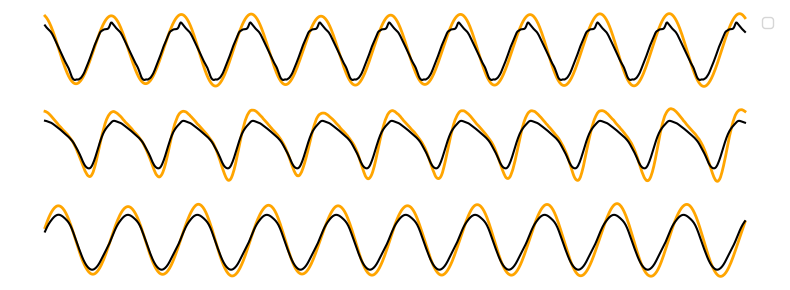

0.29806768894195557


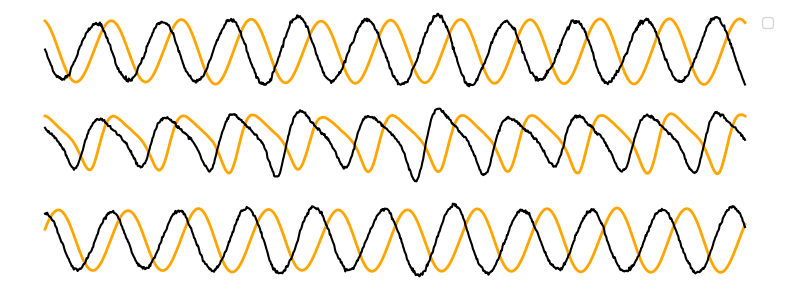

1.6763995885849


In [29]:
plot_row_figures(gt, sys_1)
mean_nrmse = compute_mean_nrmse(gt, sys_1)
print(mean_nrmse)

plot_row_figures(gt, sys_2)
mean_nrmse = compute_mean_nrmse(gt, sys_2)
print(mean_nrmse)

figure 4 B

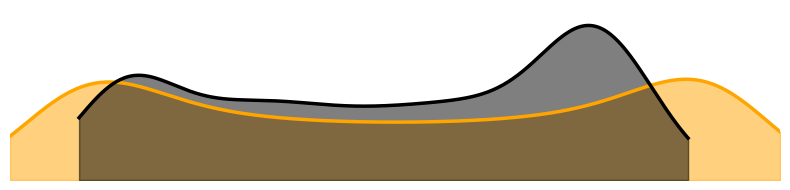

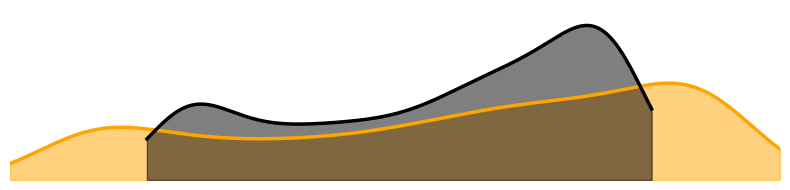

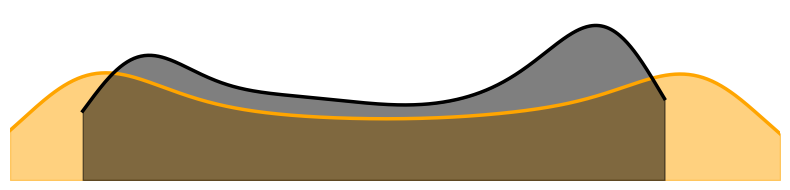

6.804418373395477


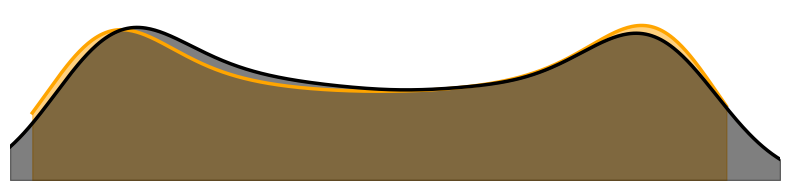

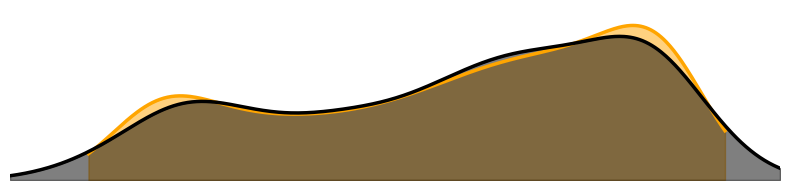

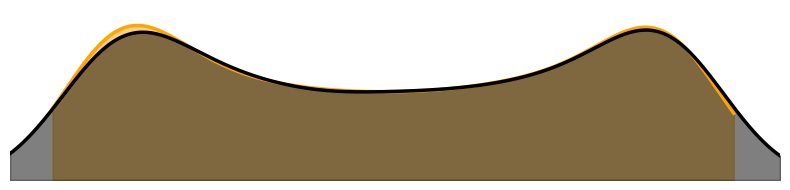

0.029360730520165773


In [30]:
[plot_probability_densities(gt[i,:], sys_1[i,:]) for i in range(gt.shape[0])]
channel_kl = calculate_kl_divergence_multi_channel(gt.T, sys_1.T)
mean_kl = np.mean(channel_kl)
print(np.mean(channel_kl))

[plot_probability_densities(gt[i,:], sys_2[i,:]) for i in range(gt.shape[0])]
channel_kl = calculate_kl_divergence_multi_channel(gt.T, sys_2.T)
mean_kl = np.mean(channel_kl)
print(np.mean(channel_kl))

figure 4C

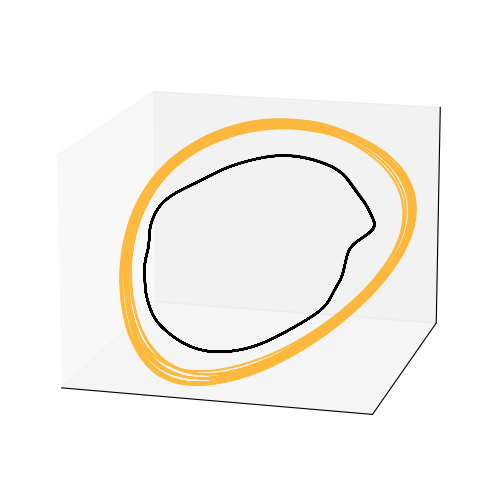

0.9762104772955845


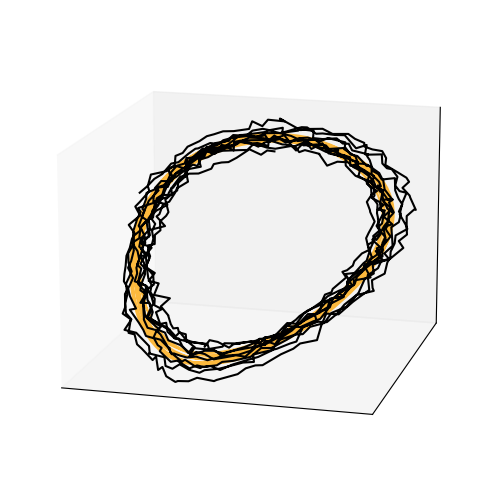

0.9900717543382535


In [31]:
plot_3d_phase_trajectory(gt,sys_1)
c_Y, c_Y_hat, similarity = compare_correlation_dimensions(gt.T, sys_1.T)
print(similarity)

plot_3d_phase_trajectory(gt,sys_2)
c_Y, c_Y_hat, similarity = compare_correlation_dimensions(gt.T, sys_2.T)
print(similarity)

figure 4 D

In [48]:
import numpy as np
data_pred=np.load('pred_data.npy')
data_real=np.load('real_data.npy')

In [50]:
def plot_brain_activation(data, subject_dir, subject="fsaverage", hemi="rh", 
                          atlas="lausanne2018.scale2", time_indices=[0], cmap="coolwarm"):
    """
    Plot cortical surface activation maps based on FreeSurfer surfaces and atlas labels.

    Parameters
    ----------
    data : np.ndarray, shape (n_regions, n_times)
        Activation values for each brain region across time points.
    subject_dir : str
        Path to FreeSurfer subjects directory.
    subject : str, default "fsaverage"
        Subject name.
    hemi : str, default "rh"
        Hemisphere, either "lh" or "rh".
    atlas : str, default "lausanne2018.scale2"
        Atlas name used for labeling.
    time_indices : list of int, default [0]
        List of time point indices to visualize.
    cmap : str, default "coolwarm"
        Colormap for activation values.

    Returns
    -------
    figs : list of matplotlib.figure.Figure
        List of figures created for each time point.
    """
    # Step 1: Load atlas labels (excluding the last two, usually medial wall etc.)
    labels_fs = mne.read_labels_from_annot(subject, atlas, subjects_dir=subject_dir)[:-2]

    # Step 2: Load annotation and surface geometry
    annot_file = os.path.join(subject_dir, subject, "label", f"{hemi}.{atlas}.annot")
    surf_file = os.path.join(subject_dir, subject, "surf", f"{hemi}.pial")
    labels, ctab, names = nib.freesurfer.read_annot(annot_file)
    vertices, faces = nib.freesurfer.read_geometry(surf_file)

    # Step 3: Check consistency between number of labels and vertices
    if len(labels) != len(vertices):
        raise ValueError(f'Mismatch: labels={len(labels)}, vertices={len(vertices)}')

    figs = []
    # Step 4: Plot activation for each requested time point
    for time_index in time_indices:
        fig = plt.figure(figsize=(10, 10))
        brain_activations = np.zeros_like(labels, dtype=np.float32)

        # Step 5: Assign activation values to each label
        for i in range(1, len(names)):  # skip the first label (background/unknown)
            brain_activations[labels == i] = data[i-1, time_index]

        # Step 6: Plot the surface statistical map
        plotting.plot_surf_stat_map(
            surf_file, brain_activations,
            hemi="right" if hemi == "rh" else "left",
            view="lateral", cmap=cmap, colorbar=False, figure=fig
        )

        figs.append(fig)

    plt.show()
    return figs

Reading labels from parcellation...
   read 58 labels from /mnt/dataset0/ws2319/fsaverage/label/lh.lausanne2018.scale2.annot
   read 58 labels from /mnt/dataset0/ws2319/fsaverage/label/rh.lausanne2018.scale2.annot


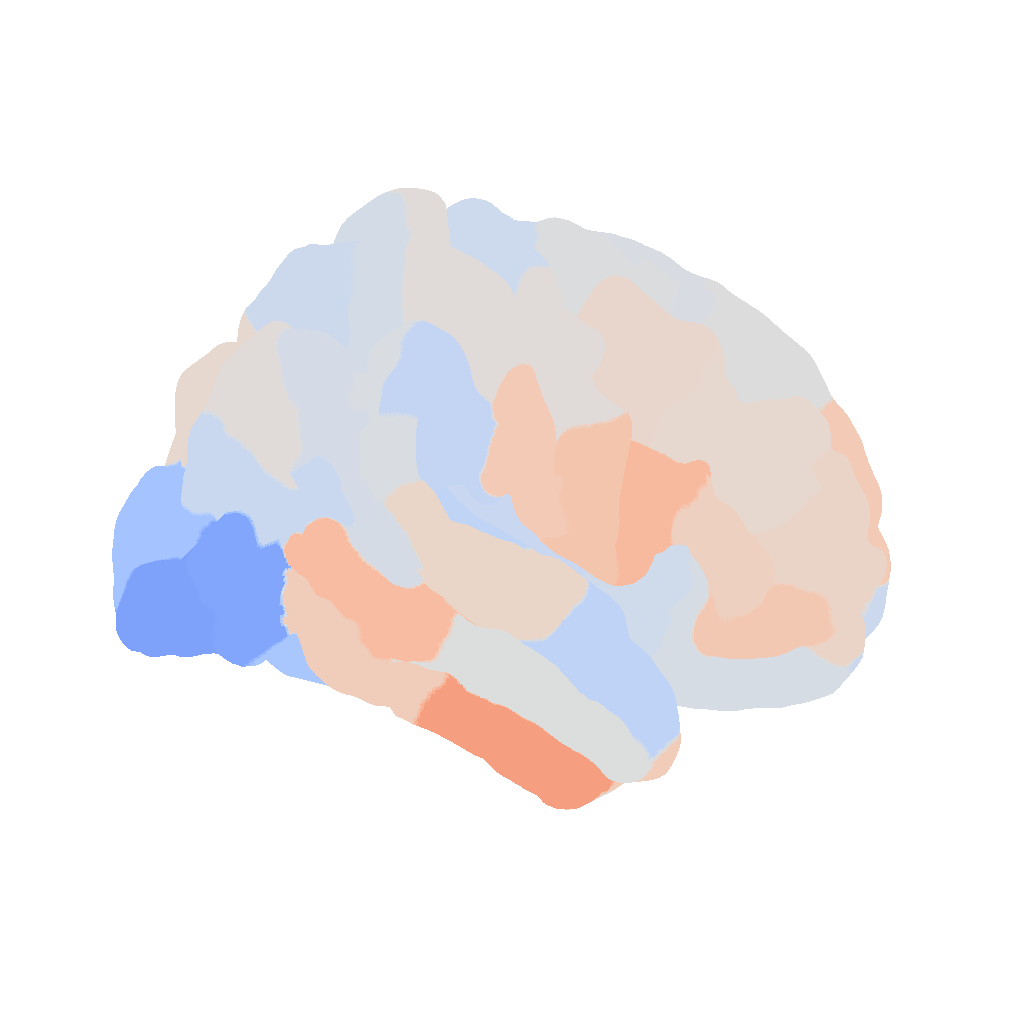

Reading labels from parcellation...
   read 58 labels from /mnt/dataset0/ws2319/fsaverage/label/lh.lausanne2018.scale2.annot
   read 58 labels from /mnt/dataset0/ws2319/fsaverage/label/rh.lausanne2018.scale2.annot


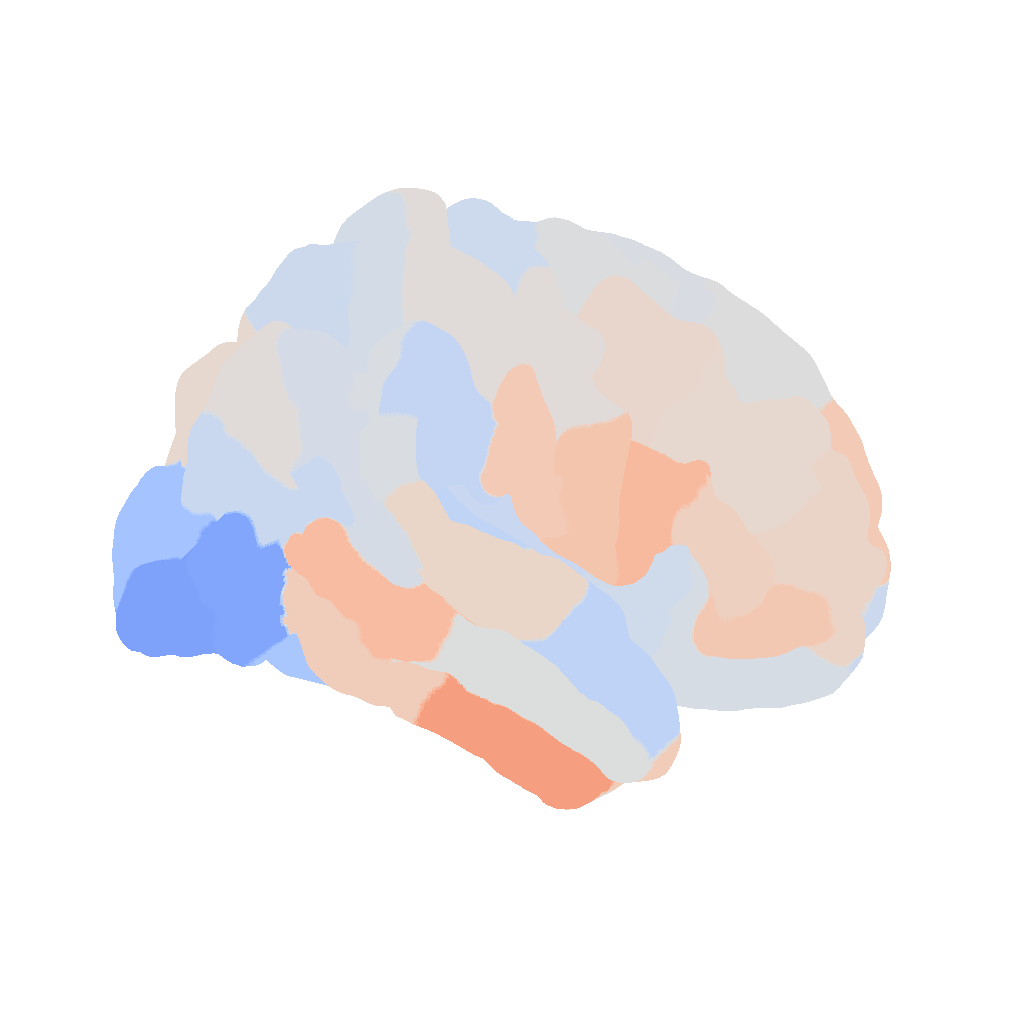

[<Figure size 1000x1000 with 1 Axes>]

In [54]:
plot_brain_activation(data_real,subject_dir='/mnt/dataset0/ws2319/',time_indices=[70])
plot_brain_activation(data_pred,subject_dir='/mnt/dataset0/ws2319/',time_indices=[70])

figure 4E

In [66]:
def plot_mean_psd_with_ci(data, fs=200, nperseg=200, fmax=30, ci=0.95, color="black"):
    """
    Compute and plot the mean Power Spectral Density (PSD) across channels 
    with a confidence interval.

    Parameters
    ----------
    data : np.ndarray, shape (n_channels, n_samples)
        Multichannel time-series data (e.g., EEG).
    fs : int, default=200
        Sampling frequency (Hz).
    nperseg : int, default=200
        Length of each segment for Welch's method.
    fmax : float, default=30
        Maximum frequency to display in the plot.
    ci : float, default=0.95
        Confidence interval level (e.g., 0.95 for 95% CI).
    color : str, default="black"
        Color for the mean PSD line and shaded CI.

    Returns
    -------
    freqs : np.ndarray
        Frequency bins.
    mean_psd : np.ndarray
        Mean PSD across channels.
    conf_int : np.ndarray
        Half-width of the confidence interval for each frequency.
    """
    # Compute PSD for each channel
    psd_all = []
    for channel_data in data:
        freqs, psd = welch(channel_data, fs=fs, nperseg=nperseg)
        psd_all.append(psd)
    psd_all = np.array(psd_all)  # shape = (n_channels, n_freqs)

    # Mean and confidence interval
    mean_psd = np.mean(psd_all, axis=0)
    stderr_psd = sem(psd_all, axis=0)
    conf_int = stderr_psd * t.ppf((1 + ci) / 2, df=psd_all.shape[0] - 1)

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(freqs, mean_psd, color=color, linewidth=2)
    plt.fill_between(freqs, mean_psd - conf_int, mean_psd + conf_int, color=color, alpha=0.3)
    plt.xlim([0, 30])
    plt.ylim([5e-7, 2e-3])
    plt.yscale('log')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power ($\mu V^2$/Hz)")
    # plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

    return freqs, mean_psd, conf_int

<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3074793/3639753036.py:50: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("Power ($\mu V^2$/Hz)")


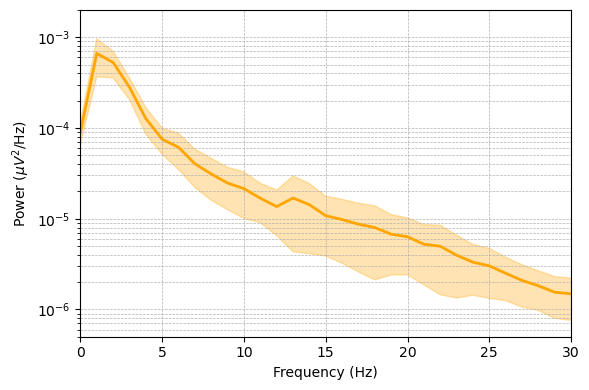

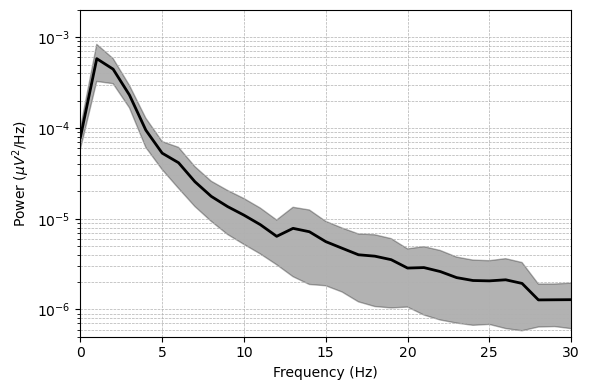

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
real_data = np.load('real_data_E.npy')
pred_data = np.load('pred_data_E.npy')

freqs, mean_psd, conf_int = plot_mean_psd_with_ci(real_data, fs=200, nperseg=200, color='orange')
freqs, mean_psd, conf_int = plot_mean_psd_with_ci(pred_data, fs=200, nperseg=200 ,color='black')

figure 4F

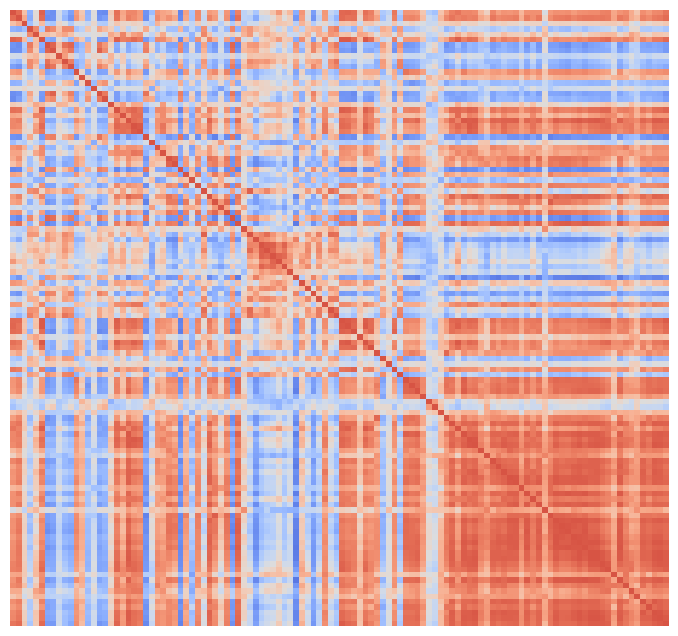

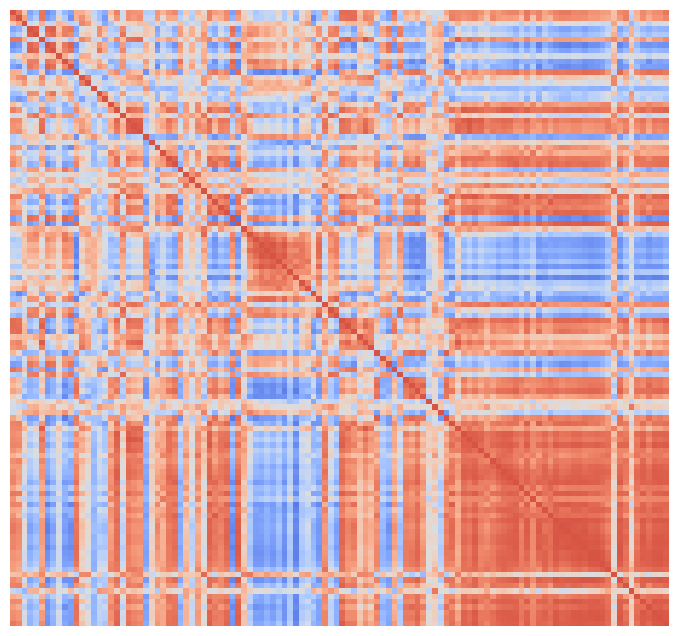

In [74]:
fc_real = np.load('real_fc.npy')
fc_pred = np.load('pred_fc.npy')

# Set vmax to a value that corresponds to the 75% color point
vmin = np.min(fc_real)-0.25
vmax = np.max(fc_real) * 1.25

# Plot real data
plt.figure(figsize=(8.5, 8))
plt.imshow(fc_real, aspect='auto', cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.show()

# Set vmax to a value that corresponds to the 75% color point
vmin = np.min(fc_pred)-0.25
vmax = np.max(fc_pred) * 1.25

# Plot predicted data
plt.figure(figsize=(8.5, 8))
plt.imshow(fc_pred, aspect='auto', cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.show()
